#### This notebook does the preprocessing and visualization of the data
##### Author: Omid Emamjomehzadeh (https://www.omidemam.com/)
##### Supervisor: Dr. Omar Wani (https://engineering.nyu.edu/faculty/omar-wani)
##### Hydrologic Systems Group @NYU (https://www.omarwani.com/)

In [1]:
# Load libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import contextily as ctx
import rasterio
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.font_manager as fm
import random
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
#import py3dep
import pyproj
from pyproj import CRS
import os
import warnings
import subprocess
from tqdm import tqdm
from watermark import watermark
import datetime

In [11]:
%%time

# Define file paths
base_dir=r'D:\culvert repo\data\initial layers'
state_shapefile_path = rf"{base_dir}\state_5070.shp"
stream_shapefile_path = rf"{base_dir}\stream_5070.shp"
stream_highres_shapefile_path = rf"{base_dir}\stream_highres_5070.shp"
road_shapefile_path = rf"{base_dir}\road_5070.shp"
street_shapefile_path = rf"{base_dir}\streets_5070.shp"
railroad_shapefile_path = rf"{base_dir}\railroad_NYS_cliped.shp"
culvert_shapefile_path = rf"{base_dir}\culvert_5070.shp"
HUC12_shapefile_path = rf"{base_dir}\HUC_12_5070.shp"
DEM_path = rf"{base_dir}\NYS_DEM_5070.tif"
bridge_path = rf"{base_dir}\NYSDOT_Bridges.shp"

# Load shapefiles
state_shapefile = gpd.read_file(state_shapefile_path)
stream_shapefile= gpd.read_file(stream_shapefile_path)
stream_highres_shapefile=gpd.read_file(stream_shapefile_path)
road_shapefile= gpd.read_file(road_shapefile_path)
street_shapefile= gpd.read_file(street_shapefile_path)
railroad_shapefile=gpd.read_file(railroad_shapefile_path).to_crs(epsg=5070)
culvert_shapefile=gpd.read_file(culvert_shapefile_path)
HUC12_shapfile=gpd.read_file(HUC12_shapefile_path)
bridge_shapefile=gpd.read_file(bridge_path).to_crs(epsg=5070)

CPU times: total: 49.7 s
Wall time: 50.9 s


In [12]:
culvert_shapefile.shape

(8561, 44)

#### Drop duplicates

In [3]:
# Drop duplicates based on the 'BIN' column and report the number of duplicated rows
initial_culvert_rows = len(culvert_shapefile)
initial_bridge_rows = len(bridge_shapefile)

# Drop duplicates 
culvert_shapefile = culvert_shapefile.drop_duplicates(subset='BIN', keep='first')
bridge_shapefile = bridge_shapefile.drop_duplicates(subset='BIN', keep='first')

# Calculate the number of dropped rows
dropped_culvert_rows = initial_culvert_rows - len(culvert_shapefile)
dropped_bridge_rows = initial_bridge_rows - len(bridge_shapefile)

# Report the number of dropped rows
print(f"The number of rows in culvert dataset is {initial_culvert_rows}, and number of duplicate rows dropped from culvert_shapefile: {dropped_culvert_rows}")
print(f"The number of rows in bridge dataset is {initial_bridge_rows}, and number of duplicate rows dropped from bridge_shapefile: {dropped_bridge_rows}")

The number of rows in culvert dataset is 8561, and number of duplicate rows dropped from culvert_shapefile: 499
The number of rows in bridge dataset is 20027, and number of duplicate rows dropped from bridge_shapefile: 11


# Plot

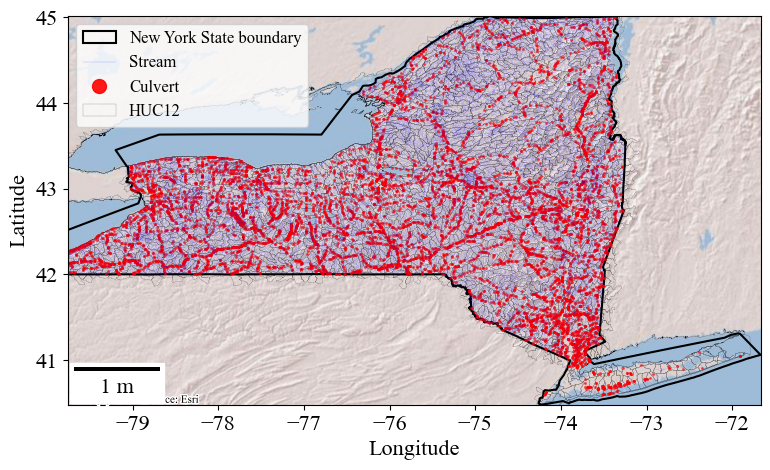

CPU times: total: 19.2 s
Wall time: 20.4 s


In [ ]:
%%time
# Ensure all shapefiles are in EPSG:3857 for compatibility with contextily basemaps
state_shapefile = state_shapefile.to_crs(epsg=4326)
road_shapefile = road_shapefile.to_crs(epsg=4326)
culvert_shapefile = culvert_shapefile.to_crs(epsg=4326)
stream_shapefile = stream_shapefile.to_crs(epsg=4326)
HUC12_shapfile=HUC12_shapfile.to_crs(epsg=4326)
bridge_shapefile=bridge_shapefile.to_crs(epsg=4326)
railroad_shapefile=railroad_shapefile.to_crs(epsg=4326)
street_shapefile=street_shapefile.to_crs(epsg=4326)
stream_highres_shapefile=stream_highres_shapefile.to_crs(epsg=4326)
# Set the font for the plot
font={'family': 'Times New Roman', 'size': 16}
plt.rc('font', **font)  

# find perfect aspect ratio
minx, miny, maxx, maxy = state_shapefile.total_bounds
data_width = maxx - minx
data_height = maxy - miny
aspect_ratio = data_width / data_height
fig_width = 9
fig_height = fig_width / aspect_ratio
# Create a new figure and axis
fig, ax = plt.subplots(figsize=(fig_width, fig_height))

# Set axis limits
minx, miny, maxx, maxy = state_shapefile.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
# Axis labels 
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

### Plot
# State
state_shapefile.plot(ax=ax, edgecolor='black', linewidth=1.5, facecolor='none', label='New York State boundary')
# HUC12
HUC12_shapfile.plot(ax=ax, edgecolor='black', linewidth=0.1, facecolor='none', label='HUC12')
# Street
#street_shapefile.plot(ax=ax, color='brown', linewidth=0.3, alpha=0.4*0.5, label='Street')
# Road
#road_shapefile.plot(ax=ax, color='orange', linewidth=0.5, alpha=0.4*0.5, label='Road')
# railroad
#railroad_shapefile.plot(ax=ax, color='black', linewidth=1, alpha=0.4*0.5, linestyle='dashed', label='Railroad')
# Bridge
#bridge_shapefile.plot(ax=ax, color='brown', markersize=1, alpha=0.3*0.5, marker='*', linestyle='None', label='Bridge')
# Culvert
culvert_shapefile.plot(ax=ax, color='red', markersize=1.5, alpha=0.5, marker='o', linestyle='None', label='Culvert')
# Stream
stream_shapefile.plot(ax=ax, color='blue', linewidth=0.1, alpha=0.5, label='Stream')

# Add basemap 
ctx.add_basemap(
    ax,
    crs=state_shapefile.crs,
    source=ctx.providers.Esri.WorldShadedRelief 
    #source=ctx.providers.NASAGIBS.ASTER_GDEM_Greyscale_Shaded_Relief
)

# legend handles
legend_handles = [
    mpatches.Patch(edgecolor='black', facecolor='none', linewidth=1.5, label='New York State boundary'),
    #Line2D([0], [0], color='brown', lw=0.3, alpha=0.7, label='Street'),
    #Line2D([0], [0], color='orange', lw=0.5, alpha=0.7, label='Road'),
    #Line2D([0], [0], color='black', lw=1, alpha=0.7, linestyle='dashed', label='Railroad'),
    Line2D([0], [0], color='blue', lw=0.3, alpha=0.3, label='Stream'),
    Line2D([0], [0], marker='o', color='red', markersize=10, alpha=0.9, linestyle='None', label='Culvert'),
    #Line2D([0], [0], marker='*', color='brown', markersize=4, alpha=0.7, linestyle='None', label='Bridge'),
    mpatches.Patch(edgecolor='black', facecolor='none', linewidth=0.1, label='HUC12')
]

# legend 
legend = ax.legend(handles=legend_handles, loc='upper left', prop={'family': 'Times New Roman', 'size': 12}, frameon=True)

# Scale bar 
scalebar = ScaleBar(1, units="m", dimension="si-length", location="lower left", scale_loc="bottom")
ax.add_artist(scalebar)

# Save
plt.savefig(r'D:\culvert repo\Results\Figures\initial_layers_basemap.png', dpi=300)

# Display
plt.show()

# Clip

In this section, each layer is clipped based on HUC12s, this operation prepares the files for parallel computing.

In [6]:
base_dir=r'D:\culvert repo\Results\Clipped_layers'

#Define output file path
output_huc12_dir = rf"{base_dir}\clipped_huc12"
output_stream_dir = rf"{base_dir}\clipped_streams"
output_road_dir = rf"{base_dir}\clipped_roads"
output_street_dir = rf"{base_dir}\clipped_street"
output_railroad_dir = rf"{base_dir}\clipped_railroad"
output_culvert_dir = rf"{base_dir}\clipped_culverts"
output_DEM_dir=rf"{base_dir}\HUC12_one meter_DEM"

# Ensure the output directories exist
os.makedirs(output_huc12_dir, exist_ok=True)
os.makedirs(output_stream_dir, exist_ok=True)
os.makedirs(output_road_dir, exist_ok=True)
os.makedirs(output_street_dir, exist_ok=True)
os.makedirs(output_railroad_dir, exist_ok=True)
os.makedirs(output_culvert_dir, exist_ok=True)
os.makedirs(output_DEM_dir, exist_ok=True)

In [7]:
state_shapefile = state_shapefile.to_crs(epsg=5070)
road_shapefile = road_shapefile.to_crs(epsg=5070)
culvert_shapefile = culvert_shapefile.to_crs(epsg=5070)
stream_shapefile = stream_shapefile.to_crs(epsg=5070)
HUC12_shapfile=HUC12_shapfile.to_crs(epsg=5070)
bridge_shapefile=bridge_shapefile.to_crs(epsg=5070)
railroad_shapefile=railroad_shapefile.to_crs(epsg=5070)
street_shapefile=street_shapefile.to_crs(epsg=5070)
stream_highres_shapefile=stream_highres_shapefile.to_crs(epsg=5070)

In [34]:
# Convert datetime fields to date only
HUC12_shapfile['loaddate'] = pd.to_datetime(HUC12_shapfile['loaddate'], errors='coerce').dt.date

# Suppress specific RuntimeWarnings from pyogrio
warnings.filterwarnings("ignore", message="Field .* create as date field, though DateTime requested")
# Iterate over each HUC12 and clipe all initial layers
for idx, row in tqdm(HUC12_shapfile.iterrows(), total=HUC12_shapfile.shape[0], desc="Processing HUC12 regions"):
    polygon = row['geometry']
    huc12 = row['huc12']

    # HUC12 
    huc12_gdf = gpd.GeoDataFrame([row], columns=HUC12_shapfile.columns, crs=HUC12_shapfile.crs)
    # Save the HUC12 
    output_huc12_path = os.path.join(output_huc12_dir, f'{huc12}_huc12.shp')
    huc12_gdf.to_file(output_huc12_path)
    
    # Stream 
    clipped_streams = stream_highres_shapefile[stream_highres_shapefile.intersects(polygon)]
    clipped_streams = gpd.clip(clipped_streams, polygon)
    if not clipped_streams.empty:
        output_stream_path = os.path.join(output_stream_dir, f'{huc12}_streams.shp')
        clipped_streams.to_file(output_stream_path)
    
    # Road 
    clipped_roads = road_shapefile[road_shapefile.intersects(polygon)]
    clipped_roads = gpd.clip(clipped_roads, polygon)
    if not clipped_roads.empty:
        output_road_path = os.path.join(output_road_dir, f'{huc12}_roads.shp')
        clipped_roads.to_file(output_road_path)

    # Railroad
    clipped_railroads = railroad_shapefile[railroad_shapefile.intersects(polygon)]
    clipped_railroads = gpd.clip(clipped_railroads, polygon)
    if not clipped_railroads.empty:
        output_railroad_path = os.path.join(output_railroad_dir, f'{huc12}_railroads.shp')
        clipped_railroads.to_file(output_railroad_path)

    # Street 
    clipped_streets = street_shapefile[street_shapefile.intersects(polygon)]
    clipped_streets = gpd.clip(clipped_streets, polygon)
    if not clipped_roads.empty:
        output_street_path = os.path.join(output_street_dir, f'{huc12}_streets.shp')
        clipped_roads.to_file(output_street_path)
    
    # Culvert
    clipped_culverts = culvert_shapefile[culvert_shapefile.intersects(polygon)]
    clipped_culverts = gpd.clip(clipped_culverts, polygon)
    if not clipped_culverts.empty:
        output_culvert_path = os.path.join(output_culvert_dir, f'{huc12}_culverts.shp')
        clipped_culverts.to_file(output_culvert_path)

Processing HUC12 regions: 100%|████████████████████████████████████████████████████| 1685/1685 [20:17<00:00,  1.38it/s]


In [8]:
# Calulate percent and list of HUCs that have all the required layers
huc12_with_all_layers = []
huc12_with_culvert=[]
# Iterate over each HUC12 
for idx, row in HUC12_shapfile.iterrows():
    huc12 = row['huc12']
    
    # Check if the corresponding clipped shapefiles exist
    clipped_streams_file = os.path.join(output_stream_dir, f'{huc12}_streams.shp')
    clipped_roads_file = os.path.join(output_road_dir, f'{huc12}_roads.shp')
    clipped_streets_file = os.path.join(output_street_dir, f'{huc12}_streets.shp')
    clipped_culverts_file = os.path.join(output_culvert_dir, f'{huc12}_culverts.shp')
    
    if os.path.exists(clipped_streams_file) and (os.path.exists(clipped_roads_file) or os.path.exists(clipped_streets_file))  and os.path.exists(clipped_culverts_file):
        huc12_with_all_layers.append(huc12)
    if os.path.exists(clipped_culverts_file):
        huc12_with_culvert.append(huc12)

# Calculate the percentage of HUC12 regions that have all the corresponding layers
total_huc12 = len(HUC12_shapfile)
huc12_with_all_layers_count = len(huc12_with_all_layers)
percentage_with_all_layers = (huc12_with_all_layers_count / len(huc12_with_culvert)) * 100

print(f'Total HUC12 regions: {total_huc12}')
print(f'HUC12 regions with culverts: {len(huc12_with_culvert)}')
print(f'HUC12 regions with culverts, roads, and stream layers: {huc12_with_all_layers_count}')
print(f'Percentage of HUC12 regions with culverts, roads, and stream layers: {percentage_with_all_layers:.2f}%')

# Save the list of HUC12 with all layers
output_list_path = r'D:\culvert repo\Results\Lists\huc12_with_all_layers.txt'
with open(output_list_path, 'w') as file:
    for huc12 in huc12_with_all_layers:
        file.write(f'{huc12}\n')
print(f'List of HUC12 regions with all layers saved to {output_list_path}')

Total HUC12 regions: 1685
HUC12 regions with culverts: 1242
HUC12 regions with culverts, roads, and stream layers: 1234
Percentage of HUC12 regions with culverts, roads, and stream layers: 99.36%
List of HUC12 regions with all layers saved to D:\culvert repo\Results\Lists\huc12_with_all_layers.txt


# Plot the cliped watersheds

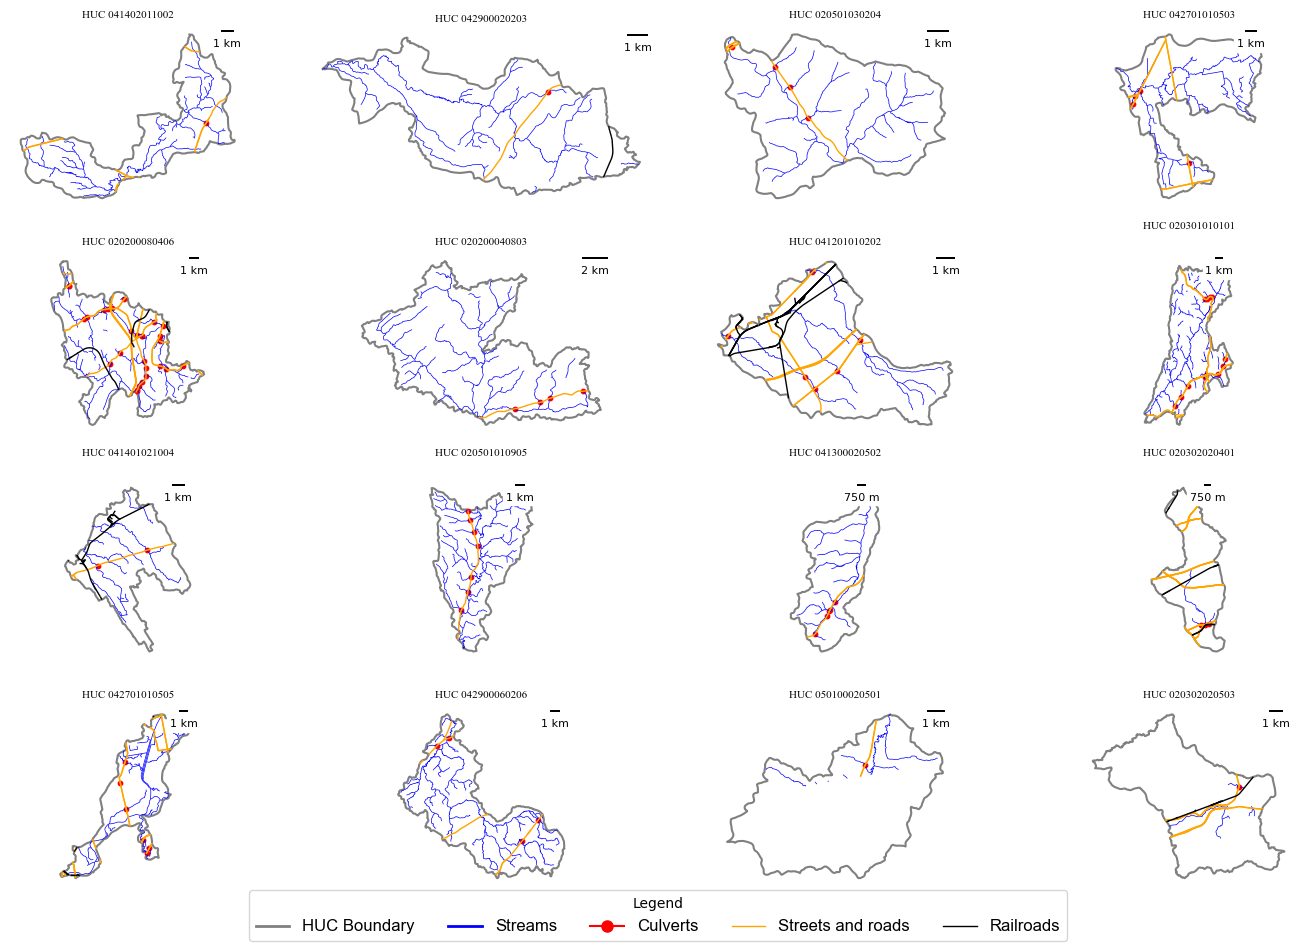

CPU times: total: 9.95 s
Wall time: 19.6 s


In [26]:
%%time
# Function to read HUC list
def read_huc_list(file_path):
    with open(file_path, 'r') as file:
        huc_list = [line.strip() for line in file.readlines()]
    return huc_list

# Read the list of HUCs
huc_list = read_huc_list(output_list_path)

# Randomly select six HUCs
selected_hucs = random.sample(huc_list, 20)

# Initialize empty lists to store dataframes
huc12_list, streams_list, culverts_list, roads_list, streets_list, railroads_list = [], [], [], [], [], []

# Paths to specific files for each selected HUC
for huc in selected_hucs:
    def load_shapefile(filepath):
        return gpd.read_file(filepath) if os.path.exists(filepath) else gpd.GeoDataFrame()

    output_huc12_path = os.path.join(output_huc12_dir, f'{huc}_huc12.shp')
    output_stream_path = os.path.join(output_stream_dir, f'{huc}_streams.shp')
    output_culvert_path = os.path.join(output_culvert_dir, f'{huc}_culverts.shp')
    output_road_path = os.path.join(output_road_dir, f'{huc}_roads.shp')
    output_street_path = os.path.join(output_street_dir, f'{huc}_streets.shp')
    output_railroad_path = os.path.join(output_railroad_dir, f'{huc}_railroads.shp')

    # Load data or fallback to empty GeoDataFrame
    huc12_list.append(load_shapefile(output_huc12_path))
    streams_list.append(load_shapefile(output_stream_path))
    culverts_list.append(load_shapefile(output_culvert_path))
    roads_list.append(load_shapefile(output_road_path))
    streets_list.append(load_shapefile(output_street_path))
    railroads_list.append(load_shapefile(output_railroad_path))

# Plot
ratio=1.2
fig, axs = plt.subplots(4, 4, figsize=(12*ratio, 8*ratio))  # Adjust rows and columns as needed

# Legend elements
legend_elements = [
    plt.Line2D([0], [0], color='gray', lw=2, label='HUC Boundary'),
    plt.Line2D([0], [0], color='blue', lw=2, label='Streams'),
    plt.Line2D([0], [0], marker='o', color='red', markersize=10, label='Culverts'),
    plt.Line2D([0], [0], color='orange', lw=1, label='Streets and roads'),
    plt.Line2D([0], [0], color='black', lw=1, label='Railroads'),
]

# Iterate through each subplot
for i, ax in enumerate(axs.flat):
    if i < len(selected_hucs):
        # Plot only if data is available
        if not huc12_list[i].empty:
            huc12_list[i].plot(ax=ax, facecolor='none', edgecolor='gray', linewidth=1.5)
        if not streams_list[i].empty:
            streams_list[i].plot(ax=ax, color='blue', linewidth=0.5)
        if not culverts_list[i].empty:
            culverts_list[i].plot(ax=ax, color='red', markersize=10)
        if not streets_list[i].empty:
            streets_list[i].plot(ax=ax, color='orange', linewidth=1)
        if not railroads_list[i].empty:
            railroads_list[i].plot(ax=ax, color='black', linewidth=1)

        # Title for each subplot
        ax.set_title(f'HUC {selected_hucs[i]}', fontname='Times New Roman', fontsize=8)

        # Add scale bar, ensuring it doesn't overlay plots
        scalebar = ScaleBar(1, units="m", dimension="si-length", location="upper right",
                            length_fraction=0.1, font_properties={'size': 8}, frameon=True)
        ax.add_artist(scalebar)

        # Add north arrow
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        
        # Hide axis
        ax.set_axis_off()

# Add legend
fig.legend(
    handles=legend_elements, 
    loc='lower center', 
    bbox_to_anchor=(0.5, -0.05), 
    ncol=6, 
    prop={'family': 'Arial', 'size': 12},
    title= 'Legend',
    markerscale=0.8,
    frameon=True
)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])  

plt.savefig(r'D:\culvert repo\Results\Figures\Clipped_layers_20_random_HUC12s.png', dpi=300)
plt.show()

In [27]:
# Date and time
now = datetime.datetime.now()
print(f"Date and time: {now}")

Date and time: 2025-04-30 14:34:52.352270


In [28]:
%load_ext watermark
# Print Python version and some dependencies
%watermark -v -m -p rasterio,geopandas,numpy,watermark,random,py3dep,pyproj,matplotlib_scalebar,pandas

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.20.0

rasterio           : 1.4.3
geopandas          : 1.0.1
numpy              : 2.0.2
watermark          : 2.4.3
random             : unknown
py3dep             : not installed
pyproj             : 3.7.1
matplotlib_scalebar: 0.9.0
pandas             : 2.2.2

Compiler    : MSC v.1940 64 bit (AMD64)
OS          : Windows
Release     : 11
Machine     : AMD64
Processor   : Intel64 Family 6 Model 183 Stepping 1, GenuineIntel
CPU cores   : 24
Architecture: 64bit

